In [48]:
%pip install nltk
%pip install keras
%pip install tensorflow
%pip install tensorflow_hub
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss


2023-10-12 21:46:23.998493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 21:46:24.032510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-12 21:46:24.032551: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-12 21:46:24.032584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-12 21:46:24.039448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 21:46:24.040364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
 # Load your dataset from the DataFrame
df = pd.read_csv('/workspaces/CONAN/CONAN/CONAN.csv')

In [4]:
# Configure the TextVectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Fit the TextVectorization layer on 'hateSpeech'
vectorize_layer.adapt(df['hateSpeech'])

# Create a label mapping for 'hsSubType'
label_mapping = {subtype: label for label, subtype in enumerate(df['hsSubType'].unique())}
num_classes = len(label_mapping)
len(label_mapping)


23

In [5]:
batch_size = 16
# Define a function to vectorize the text and return the labels
def vectorize_text(text, label):
    #text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Map 'hsSubType' to integer labels
df['label'] = df['hsSubType'].map(label_mapping)
# Split the data into training (80%) and the remaining (20%)
train_df, remaining_df = train_test_split(df, test_size=0.2, random_state=42)

# Create a TensorFlow dataset for training
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df['hateSpeech'], train_df['label']))
train_ds = raw_train_ds.map(vectorize_text)
#train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Further split the remaining data into validation (10%) and test (10%)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Create a TensorFlow dataset for validation
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df['hateSpeech'], val_df['label']))
val_ds = raw_val_ds.map(vectorize_text)
#val_ds = raw_val_ds.map(vectorize_text).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create a TensorFlow dataset for testing
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_df['hateSpeech'], test_df['label']))
test_ds = raw_test_ds.map(vectorize_text)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
#Check the dataset shapes: Print the shapes of the batches in train_ds and val_ds using a loop to ensure they match the expected shapes.
for text_batch, label_batch in train_ds.take(1):
    print('text_batch shape:', text_batch.shape)
    print('label_batch shape:', label_batch.shape)
    

text_batch shape: (16, 250)
label_batch shape: (16,)


2023-10-12 21:46:28.209026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
#print the mapping
print(label_mapping)

{'crimes': 0, 'crimes , culture': 1, 'crimes , culture , rapism': 2, 'crimes , culture , women': 3, 'crimes , rapism': 4, 'crimes , rapism , terrorism': 5, 'culture': 6, 'culture , generic': 7, 'culture , islamization': 8, 'culture , women': 9, 'economics': 10, 'generic': 11, 'islamization': 12, 'islamization , rapism': 13, 'rapism': 14, 'rapism , terrorism': 15, 'terrorism': 16, 'women': 17, 'crimes , women': 18, 'culture , terrorism': 19, 'islamization , terrorism': 20, 'islamization , women': 21, 'rapism , women': 22}


In [8]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))
print('Number of classes: {}'.format(num_classes))

# Reverse the numerical mapping to get 'hsSubType' from label
reverse_mapping = {v: k for k, v in label_mapping.items()}
print("Label 0 corresponds to", reverse_mapping[0])
print("Label 1 corresponds to", reverse_mapping[1])

1287 --->  fundamental
 313 --->  se
Vocabulary size: 2692
Number of classes: 23
Label 0 corresponds to crimes
Label 1 corresponds to crimes , culture


<Axes: ylabel='label'>

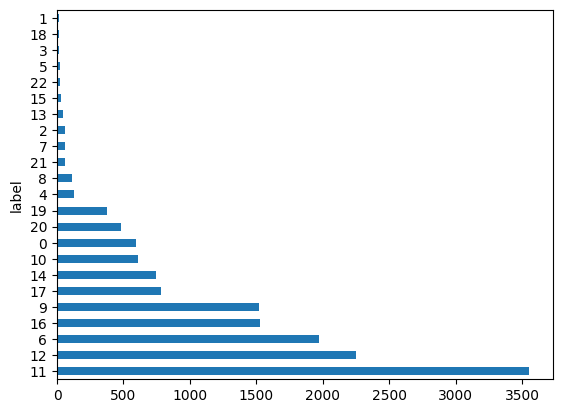

In [9]:
df['label'].value_counts().plot(kind='barh')

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for text_batch, label_batch in train_ds.take(1):
    print('text_batch shape:', text_batch.shape)
    print('label_batch shape:', label_batch.shape)
    

text_batch shape: (16, 250)
label_batch shape: (16,)


2023-10-12 21:46:28.656938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-10-12 21:46:28.656980: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

# print model input shape
print("Input shape:", train_ds.element_spec[0].shape)
model.summary()

Input shape: (None, None)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0

In [32]:
# Imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


n_features = 250
epochs = 60

# Create the model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=n_features))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(),
              metrics=['accuracy'])

# Fit data to the model
history = model.fit(train_ds,  # Use your training dataset
          validation_data=val_ds,  # Use your validation dataset
          epochs=epochs,  # Use the number of epochs you've defined
          verbose=1)

# Generate generalization metrics
score = model.evaluate(test_ds, verbose=0)  # Use your test dataset
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')



Epoch 1/60


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 2s 2ms/step - loss: 3.6065 - accuracy: 0.2307 - val_loss: 2.7069 - val_accuracy: 0.2168
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 2.5143 - accuracy: 0.2535 - val_loss: 2.4837 - val_accuracy: 0.2422
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 2.3707 - accuracy: 0.2621 - val_loss: 2.4047 - val_accuracy: 0.2415
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 2.3022 - accuracy: 0.2631 - val_loss: 2.3476 - val_accuracy: 0.2428
Epoch 5/60
750/750 [==============================] - 1s 1ms/step - loss: 2.2639 - accuracy: 0.2636 - val_loss: 2.3977 - val_accuracy: 0.2455
Epoch 6/60
750/750 [==============================] - 1s 1ms/step - loss: 2.2529 - accuracy: 0.2632 - val_loss: 2.2886 - val_accuracy: 0.2415
Epoch 7/60
750/750 [==============================] - 1s 1ms/step - loss: 2.2325 - accuracy: 0.2633 - val_loss: 2.2923 - val_accuracy: 0.2382
Epoch 8/60
750/75

In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

94/94 [==============================] - 0s 989us/step - loss: 2.2748 - accuracy: 0.2695
Loss:  2.2747602462768555
Accuracy:  0.26951301097869873


In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

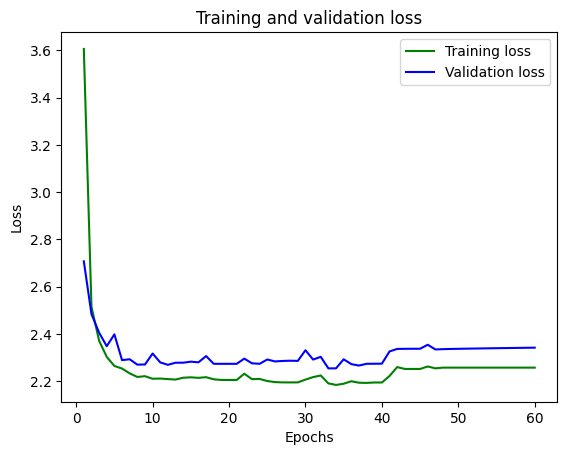

In [35]:
accuracy = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

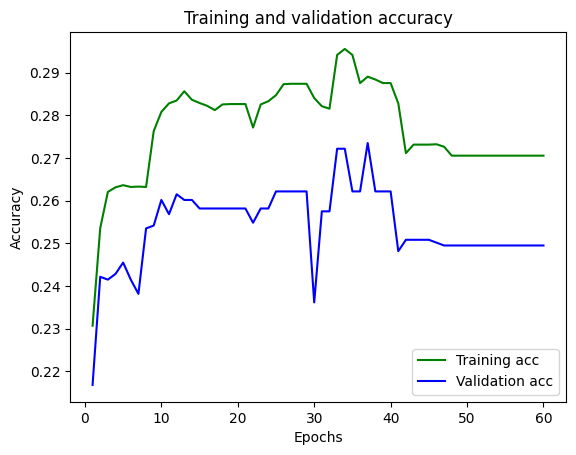

In [36]:
plt.plot(epochs, accuracy, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [37]:
# Save the model
model.save("my_trained_model")


INFO:tensorflow:Assets written to: my_trained_model/assets


INFO:tensorflow:Assets written to: my_trained_model/assets


In [38]:
# Load the saved model
loaded_model = tf.keras.models.load_model("my_trained_model")


In [47]:
input_sentence = "Islam is a religion of peace"

# Vectorize the sentence
vectorized_sentence = vectorize_layer([input_sentence])

# Make predictions
predictions = loaded_model.predict(vectorized_sentence)
print(predictions)

predicted_class = np.argmax(predictions)
# Reverse the numerical mapping to get 'hsSubType' from label
reverse_mapping = {v: k for k, v in label_mapping.items()}
print("Predicted Class:", reverse_mapping[predicted_class])

1/1 [==============================] - 0s 15ms/step
[[0.04119586 0.00059787 0.00422453 0.00111131 0.00825022 0.00125157
  0.11568934 0.00413581 0.00697318 0.09463724 0.04058827 0.24719025
  0.15480608 0.00298935 0.05180588 0.00187618 0.1025319  0.05305369
  0.00084371 0.02590764 0.03501568 0.00395224 0.00137216]]
Predicted Class: generic


In [ ]:
print(label_mapping)

{'crimes': 0, 'crimes , culture': 1, 'crimes , culture , rapism': 2, 'crimes , culture , women': 3, 'crimes , rapism': 4, 'crimes , rapism , terrorism': 5, 'culture': 6, 'culture , generic': 7, 'culture , islamization': 8, 'culture , women': 9, 'economics': 10, 'generic': 11, 'islamization': 12, 'islamization , rapism': 13, 'rapism': 14, 'rapism , terrorism': 15, 'terrorism': 16, 'women': 17, 'crimes , women': 18, 'culture , terrorism': 19, 'islamization , terrorism': 20, 'islamization , women': 21, 'rapism , women': 22}


# Creation of an API

In [43]:
from flask import Flask, request, jsonify
import threading
import time

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    # Process and make predictions with your model here
    # For demonstration, let's just return a sample response
    response = {'result': 'Sample prediction'}
    return jsonify(response)

def run_flask_app():
    app.run(host='0.0.0.0', port=5000)

# Start the Flask app in a separate thread
flask_thread = threading.Thread(target=run_flask_app)
flask_thread.start()

# Give some time for the Flask app to start
time.sleep(2)

# You can now send requests to the /predict endpoint in another cell


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.16.5.4:5000
INFO:werkzeug:Press CTRL+C to quit


INFO:werkzeug:127.0.0.1 - - [12/Oct/2023 21:59:54] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [12/Oct/2023 21:59:54] "GET /favicon.ico HTTP/1.1" 404 -
